In [3]:
%matplotlib notebook
from bmcs_utils.api import InteractiveModel, IPWInteract 
import traits.api as tr
import matplotlib.pylab as plt
import numpy as np
import sympy as sp

In [50]:
x, M, L = sp.symbols('x, M, L')


M_ = sp.Piecewise((2*M*x/L, x < L/2),
             (2*M*(1-x/L), x>=L/2)
            )

M_

Piecewise((2*M*x/L, x < L/2), (2*M*(1 - x/L), True))

In [51]:
get_M = sp.lambdify((x,M,L), M_)

In [52]:
%%html
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>

In [61]:
class Beam3PtBending(InteractiveModel):
    
    name = 'Geometry'
    
    L = tr.Float(400, param=True, latex='L', minmax=(100,1000))
    H = tr.Float(100, param=True, latex='H', minmax=(100,1000))
    F = tr.Float(100, param=True, latex='F', minmax=(1,1000))
    n_x = tr.Float(100, param=True, latex='n_x', minmax=(1,1000))
        
    param_names = ['L', 'H', 'F']

    def get_M_x(self):
        x = np.linspace(0,self.L,self.n_x)
        M = self.F / 2/1000 * self.L / 2
        M_x = get_M(x,M,self.L)
        return x, M_x
    
    def get_phi_x(self):
        x, M_x = self.get_M_x()
        phi_x = np.trapz(M_x, x)
    
    def add_subplot(self,fig):
        return fig.add_subplot(1,1,1)
    
    
    def update_plot(self, ax):
        ax.axis('equal');
        ax.fill([0,self.L,self.L,0,0], [0,0,self.H,self.H,0],color='gray')
        ax.plot([0,self.L,self.L,0,0], [0,0,self.H,self.H,0],color='black')
        x, M_x = self.get_M_x()
        ax.plot(x, M_x, color='red')

<IPython.core.display.Javascript object>


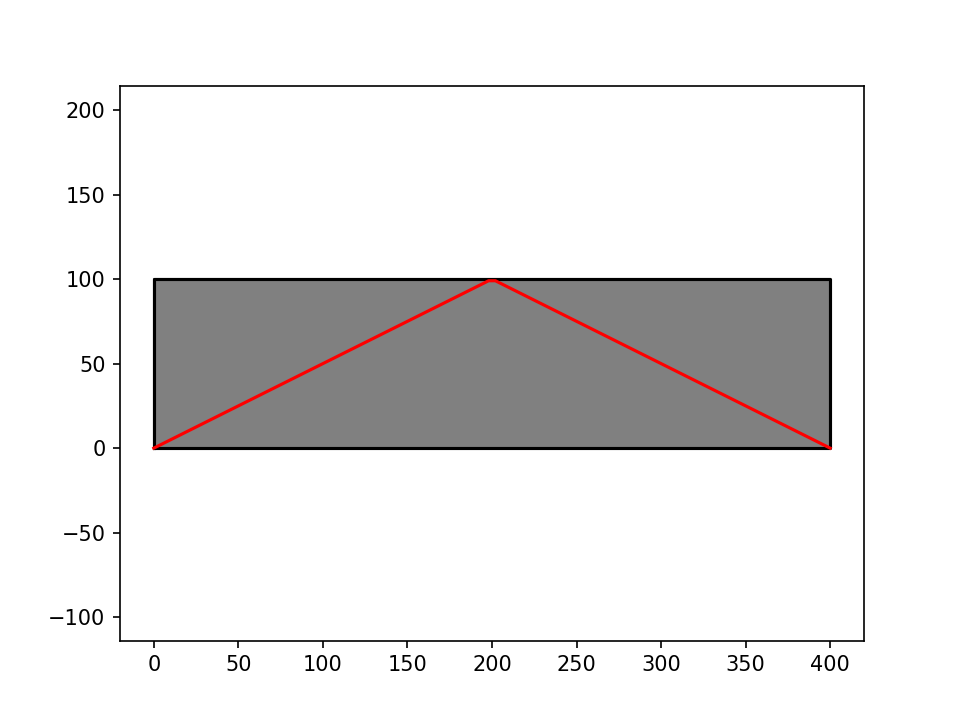

In [62]:
bd = Beam3PtBending()
ibd = IPWInteract(bd)
ibd.interact()